In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reproduce_COMPTEL_constraints_v2 import read_blackhawk_spectra, load_data
from tqdm import tqdm
import matplotlib as mpl

In [2]:
plt.rcParams['font.size'] = 13
plt.rcParams['text.usetex'] = False

Constants

In [3]:
# Express all quantities in [g, cm, microgauss, s]

# physical constants
k_B = 8.617333262e-8  # Boltzmann constant, in keV / K
c = 2.99792458e10  # speed of light, in cm / s

# unit conversions
keV_to_K = 1.160451812e7 * k_B
kpc_to_cm = 3.0857e21
Mpc_to_cm = 3.0857e24
erg_to_GeV = 624.15064799632
solMass_to_g = 1.989e33

# electron/positron mass, in GeV / c^2
m_e = 5.11e-4 / c ** 2

# quantities from Table I of Lee & Chan (2021) for A262
T_c_keV = 1
T_c_K = T_c_keV * keV_to_K
rho_s = 14.1e14 * solMass_to_g / (Mpc_to_cm) ** 3
r_s = 172 * kpc_to_cm
R = 2 * kpc_to_cm
z = 0.0161
beta = 0.433
r_c = 30 * kpc_to_cm
n_0 = 0.94e-2
B_0 = 2.9
L_0 = 5.6e38 * erg_to_GeV 



Ranges

In [4]:
n_steps = 1000

# energy range to integrate over (in GeV)
E_min = m_e * c ** 2
E_max = 5
E_values = 10 ** np.linspace(np.log10(E_min), np.log10(E_max), n_steps)

# radius range
r_min = 1e-3
r_values = 10 ** np.linspace(np.log10(r_min), np.log10(R), n_steps)


Other parameters

In [5]:
extension = "A262"

epsilon = 0.5  # choose 0.5 to maximise magnetic field

const_B = True
scipy = False
trapz = True
numbered_mass_range = True

MATTS MATHS

In [6]:
# DM density for a NFW profile, in g cm^{-3}
def rho_NFW(r):
    return rho_s * (r_s / r) / (1 + (r / r_s)) ** 2

# number density, in cm^{-3}
def n(r):
    return n_0 * (1 + r ** 2 / r_c ** 2) ** (-3 * beta / 2)

# magnetic field, in microgauss
def B(r):
    if const_B:
        return B_0
    else:
        return 11 * epsilon ** (-0.5) * np.sqrt(n(r) / 0.1) * (T_c_keV / 2) ** (3 / 4)

# Lorentz factor
def gamma(E):
    return E / (m_e * c ** 2)

# Depends on number density n(r) function
def b_Coul(E, r):
    return 1e-16 * (6.13 * n(r) * (1 + (1 / 75) * np.log(gamma(E) / n(r))))

# Depends on number density n(r), b_Coul(n_r)
def b_T(E, r):
    b_IC = 1e-16 * (0.25 * E ** 2 * (1+z)**4)
    b_syn = 1e-16 * (0.0254 * E ** 2 * B(r) ** 2)
    b_brem = 1e-16 * (1.51 * n(r) * (np.log(gamma(E) / n(r)) + 0.36))
    return b_IC + b_syn + b_brem + b_Coul(E, r)


# def spec(E, ep_energies, ep_spec):
#     return np.interp(E, ep_energies, ep_spec)


# def Q(E, r, m_pbh, ep_energies, ep_spec):
#     return spec(E, ep_energies, ep_spec) * rho_NFW(r) / m_pbh


# def dndE(E, r, m_pbh, ep_energies, ep_spec):
#     E_prime_values = 10 ** np.linspace(np.log10(E), np.log10(E_max), n_steps)
#     Q_values = [Q(E_prime, r, m_pbh, ep_energies, ep_spec) for E_prime in E_prime_values]
    
#     if trapz:
#         return np.trapz(Q_values, E_prime_values) / b_T(E, r)

#     if scipy:
#         return quad(Q, E, E_max, args=(r, m_pbh, ep_energies, ep_spec))[0] / b_T(E, r)

# def L_integrand(E, r, m_pbh, ep_energies, ep_spec):
#     return dndE(E, r, m_pbh, ep_energies, ep_spec) * r ** 2 * b_Coul(E, r)


# def L(m_pbh, ep_energies, ep_spec):

#     if trapz:
#         integrand = [np.trapz(L_integrand(E_values, r, m_pbh, ep_energies, ep_spec), E_values) for r in r_values]
#         return 4 * np.pi * np.trapz(integrand, r_values)

#     if scipy:
#         return 4 * np.pi * np.array(dblquad(L_integrand, r_min, R, E_min, E_max, args=(m_pbh, ep_energies, ep_spec) )[0])


In [7]:

if numbered_mass_range == True:
    #m_pbh_values = 10 ** np.linspace(np.log10(5e14), 17, 25)
    m_pbh_values = 10 ** np.linspace(np.log10(5e14), 19, 20)
    file_path_data_base = "../Downloads/version_finale/results/"


f_pbh_values = []

energies_ref = 10 ** np.linspace(np.log10(E_min), np.log10(E_max), n_steps)



In [8]:
# def main():
#     for i, m_pbh in tqdm(enumerate(m_pbh_values), total=len(m_pbh_values)):

#         #file_path_data = file_path_data_base + "LC21_{:.0f}/".format(i + 1)
#         file_path_data = file_path_data_base + "LC21_higherM_{:.0f}/".format(i + 1)

#         ep_energies_load, ep_spec_load = read_blackhawk_spectra(
#             file_path_data + "instantaneous_secondary_spectra.txt", col=2
#         )

#         ep_energies = ep_energies_load[ep_spec_load > 0]
#         ep_spec = ep_spec_load[ep_spec_load > 0]

#         print("M_PBH = {:.2e} g".format(m_pbh))

#         # Evaluate photon spectrum at a set of pre-defined energies
#         luminosity_predicted = L(m_pbh, ep_energies, ep_spec)
#         f_pbh_values.append(L_0 / luminosity_predicted)


## Testing testing

Use the lower value of black hole mass

In [9]:
file_path_extracted = "."
m_pbh_LC21_extracted, f_PBH_LC21_extracted = load_data(
    "LC21_" + extension + "_NFW.csv"
)

f_pbh_values = []
# main()


In [10]:
from scipy.integrate import cumulative_trapezoid

def density_sq(r):
    return rho_s * r_s * r / (1 + (r/r_s))**2

def b_term(E, r):
    return b_Coul(E, r)/b_T(E, r)

def integral(m, rvals, ep_spec, ep_energies):
    
    Rs, Es = np.meshgrid(rvals, ep_energies)

    spectral_int = cumulative_trapezoid(ep_spec, ep_energies, initial=0)
    spectral_int = spectral_int[-1] - spectral_int

    r_terms = density_sq(Rs)
    b_terms = b_term(Es, Rs)
    
    integrand = r_terms*b_terms*spectral_int[:,np.newaxis]
    
    temp = np.trapz(integrand, x=ep_energies, axis=0)
    res  = np.trapz(temp, x=rvals)
    
    return res*np.pi*4/m




f_pbh_values_new = []
for i, m_pbh in tqdm(enumerate(m_pbh_values), total=len(m_pbh_values)):

    #file_path_data = file_path_data_base + "LC21_{:.0f}/".format(i + 1)
    file_path_data = file_path_data_base + "LC21_higherM_{:.0f}/".format(i + 1)

    ep_energies_load, ep_spec_load = read_blackhawk_spectra(
        file_path_data + "instantaneous_secondary_spectra.txt", col=2
    )

    ep_energies = ep_energies_load[ep_spec_load > 1e10]
    ep_spec = ep_spec_load[ep_spec_load > 1e10]

    # Evaluate photon spectrum at a set of pre-defined energies
    luminosity_predicted = integral(m_pbh, r_values, ep_spec, ep_energies)
    f_pbh_values_new.append(L_0 / luminosity_predicted)

    

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 25.26it/s]


Expected value:

In [17]:
extracted_interpolated = 10 ** np.interp(
    np.log10(m_pbh_values),
    np.log10(m_pbh_LC21_extracted),
    np.log10(f_PBH_LC21_extracted),
)
extracted_interpolated_fewer = []
m_pbh_fewer = []
for i in range(0, len(extracted_interpolated)):
    if i % 1 == 0:
        extracted_interpolated_fewer.append(extracted_interpolated[i])
        m_pbh_fewer.append(m_pbh_values[i])
        

ratio_new = extracted_interpolated_fewer / np.array(f_pbh_values_new)

# expected = extracted_interpolated_fewer[N]

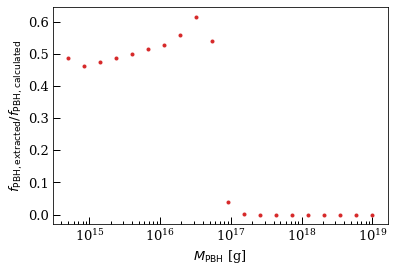

In [18]:
plt.figure()
# plt.plot(m_pbh_fewer, ratio, "x")
plt.plot(m_pbh_fewer, ratio_new, ".", color='C3')
plt.xlabel("$M_\mathrm{PBH}$ [g]")
plt.ylabel("$f_\mathrm{PBH, extracted} / f_\mathrm{PBH, calculated}$")
plt.xscale("log")

Check if the interpolation is good:

In [13]:
# plt.plot(m_pbh_LC21_extracted, f_PBH_LC21_extracted)
# # plt.axvline(m_pbh_values[N], color='k', lw=1)
# plt.scatter(m_pbh_values, extracted_interpolated_fewer, color='k', s=100)
# # plt.scatter(m_pbh_values[:10], np.array(f_pbh_values[:10]), color='C3', s=100)

# plt.xscale('log')
# plt.yscale('log')

# plt.xlim(1e15, 1e17)
# plt.ylim(1e-6, 1)

In [14]:
# # Evaluate photon spectrum at a set of pre-defined energies
# # luminosity_predicted = L(m_pbh, ep_energies, ep_spec)
# # f_pbh_values.append(L_0 / luminosity_predicted)

# calculated = f_pbh_values[N]

In [15]:
# # DM density for a NFW profile, in g cm^{-3}
# def rho_NFW(r):
#     return rho_s * (r_s / r) / (1 + (r / r_s)) ** 2

# # number density, in cm^{-3}
# def n(r):
#     return n_0 * (1 + r ** 2 / r_c ** 2) ** (-3 * beta / 2)

# # magnetic field, in microgauss
# def B(r):
#     if const_B:
#         return B_0
#     else:
#         return 11 * epsilon ** (-0.5) * np.sqrt(n(r) / 0.1) * (T_c_keV / 2) ** (3 / 4)

# # Lorentz factor
# def gamma(E):
#     return E / (m_e * c ** 2)

# # Depends on number density n(r) function
# def b_Coul(E, r):
#     return 1e-16 * (6.13 * n(r) * (1 + (1 / 75) * np.log(gamma(E) / n(r))))

# # Depends on number density n(r), b_Coul(n_r)
# def b_T(E, r):
#     b_IC = 1e-16 * (0.25 * E ** 2 * (1+z)**4)
#     b_syn = 1e-16 * (0.0254 * E ** 2 * B(r) ** 2)
#     b_brem = 1e-16 * (1.51 * n(r) * (np.log(gamma(E) / n(r)) + 0.36))
#     return b_IC + b_syn + b_brem + b_Coul(E, r)


# def spec(E, ep_energies, ep_spec):
#     return np.interp(E, ep_energies, ep_spec)


# def Q(E, r, m_pbh, ep_energies, ep_spec):
#     return spec(E, ep_energies, ep_spec) * rho_NFW(r) / m_pbh


# def dndE(E, r, m_pbh, ep_energies, ep_spec):
#     E_prime_values = 10 ** np.linspace(np.log10(E), np.log10(E_max), n_steps)
#     Q_values = [Q(E_prime, r, m_pbh, ep_energies, ep_spec) for E_prime in E_prime_values]
    
#     if trapz:
#         return np.trapz(Q_values, E_prime_values) / b_T(E, r)

#     if scipy:
#         return quad(Q, E, E_max, args=(r, m_pbh, ep_energies, ep_spec))[0] / b_T(E, r)

# def L_integrand(E, r, m_pbh, ep_energies, ep_spec):
#     return dndE(E, r, m_pbh, ep_energies, ep_spec) * r ** 2 * b_Coul(E, r)


# def L(m_pbh, ep_energies, ep_spec):

#     if trapz:
#         integrand = [np.trapz(L_integrand(E_values, r, m_pbh, ep_energies, ep_spec), E_values) for r in r_values]
#         return 4 * np.pi * np.trapz(integrand, r_values)

#     if scipy:
#         return 4 * np.pi * np.array(dblquad(L_integrand, r_min, R, E_min, E_max, args=(m_pbh, ep_energies, ep_spec) )[0])


In [16]:

# index = 40
# f_pbh_PL = f_PBH_LC21_extracted[0] * np.exp(40 * m_pbh_LC21_extracted / m_pbh_LC21_extracted[0])


# extracted_interpolated = 10 ** np.interp(
#     np.log10(m_pbh_values),
#     np.log10(m_pbh_LC21_extracted),
#     np.log10(f_PBH_LC21_extracted),
# )
# extracted_interpolated_fewer = []
# m_pbh_fewer = []
# for i in range(0, len(extracted_interpolated)):
#     if i % 1 == 0:
#         extracted_interpolated_fewer.append(extracted_interpolated[i])
#         m_pbh_fewer.append(m_pbh_values[i])
# # ratio = extracted_interpolated_fewer / np.array(f_pbh_values)
# # frac_diff = ratio - 1

# ratio_new = extracted_interpolated_fewer / np.array(f_pbh_values_new)

# plt.figure()
# # plt.plot(m_pbh_fewer, f_pbh_values)
# plt.plot(m_pbh_LC21_extracted, f_PBH_LC21_extracted, label="Extracted (Fig. 1)")
# plt.xlabel("$M_\mathrm{PBH}$ [g]")
# plt.ylabel("$f_\mathrm{PBH}$")
# plt.title("extension")
# plt.tight_layout()
# plt.legend()
# #plt.ylim(1e-8, 1)
# #plt.xlim(4e14, 1e17)
# plt.yscale("log")
# plt.xscale("log")

# plt.figure()
# # plt.plot(m_pbh_fewer, ratio, "x")
# plt.plot(m_pbh_fewer, ratio_new, ".", color='C3')
# plt.xlabel("$M_\mathrm{PBH}$ [g]")
# plt.ylabel("$f_\mathrm{PBH, extracted} / f_\mathrm{PBH, calculated}$")
# plt.xscale("log")

# # plt.yscale('log')
# #plt.xlim(4e14, 6e16)  # upper limit is where f_PBH = 1 in Fig. 1 of Lee & Chan (2021)
# plt.title(extension)
# plt.tight_layout()

# plt.figure()
# # plt.plot(m_pbh_fewer, frac_diff, "x")
# plt.xlabel("$M_\mathrm{PBH}$ [g]")
# plt.ylabel("$(f_\mathrm{PBH, extracted} / f_\mathrm{PBH, calculated}) - 1$")
# plt.xscale("log")
# # plt.yscale('log')
# plt.xlim(4e14, 6e16)  # upper limit is where f_PBH = 1 in Fig. 1 of Lee & Chan (2021)
# plt.title(extension)
# plt.tight_layout()

# print("f_PBH =", f_pbh_values)
# # print("ratio =", ratio)
# # print("fractional difference =", frac_diff)